In [1]:
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
import venn

In [2]:
plt.rc('font', size=20)
plt.rc('font', family='Roboto')

colors = ["#1b9e77","#d95f02","#7570b3","#e6ab02"]
experiment_results = [
    ('../autofl/weighted_fl_results/accat1_de', 'Equal Weight', 'equal', 'accs', True),
    ('../autofl/weighted_fl_results/accat1_de', 'DE Ensemble', 'de', 'total_accs', True),
    ('../autofl/weighted_fl_results/llama3', 'Llama3', 'equal', 'accs', False),
    ('../autofl/weighted_fl_results/llama3.1', 'Llama3.1', 'equal', 'accs', False),
    ('../autofl/weighted_fl_results/mistral-nemo', 'Mistral NeMo', 'equal', 'accs', False),
    ('../autofl/weighted_fl_results/qwen2.5-coder', 'Qwen2.5-Coder', 'equal', 'accs', False),
]

In [3]:
def read_combined_fl_result(path,k=1):
    with open(path) as f:
        result = json.load(f)
    buggy_methods = result['buggy_methods']
    ranked_at_k = set() 
    for bug, methods in buggy_methods.items():
        if not methods:
            continue

        for rank in methods.values():
            if rank['autofl_rank'] <= k:
                ranked_at_k.add(bug)
                break
    
    return ranked_at_k

In [4]:
def draw_overlap_for_combined_fl(k):
    target_sets = [read_combined_fl_result('../autofl/preliminary_results/d4j_llama3_template2.json', k),\
                read_combined_fl_result('../autofl/preliminary_results/d4j_gemma2_template2.json', k)]
    plt.figure()
    venn2(target_sets, ['', ''])
    plt.tight_layout()
    plt.savefig(f'approach_overlap.pdf', dpi=300)
    plt.show()

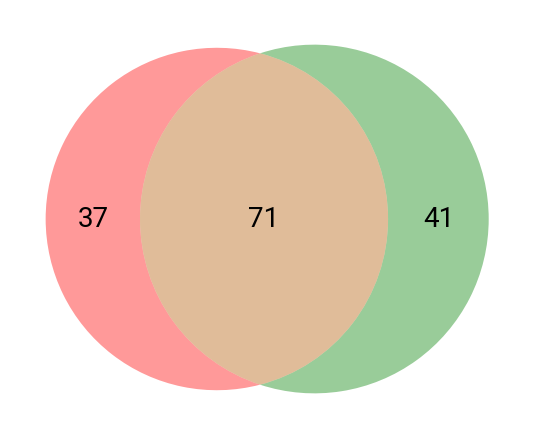

In [5]:
draw_overlap_for_combined_fl(1)

# RQ 1. Effectiveness

### Overlap Diagram

In [6]:
def read_combined_fl_result(path,k=1):
    with open(path) as f:
        result = json.load(f)
    buggy_methods = result['buggy_methods']
    ranked_at_k = set() 
    for bug, methods in buggy_methods.items():
        if not methods:
            continue

        for rank in methods.values():
            if rank['autofl_rank'] <= k:
                ranked_at_k.add(bug)
                break
    
    return ranked_at_k

/Users/hyunjoon/anaconda3/envs/test/lib/python3.9/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/Users/hyunjoon/anaconda3/envs/test/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


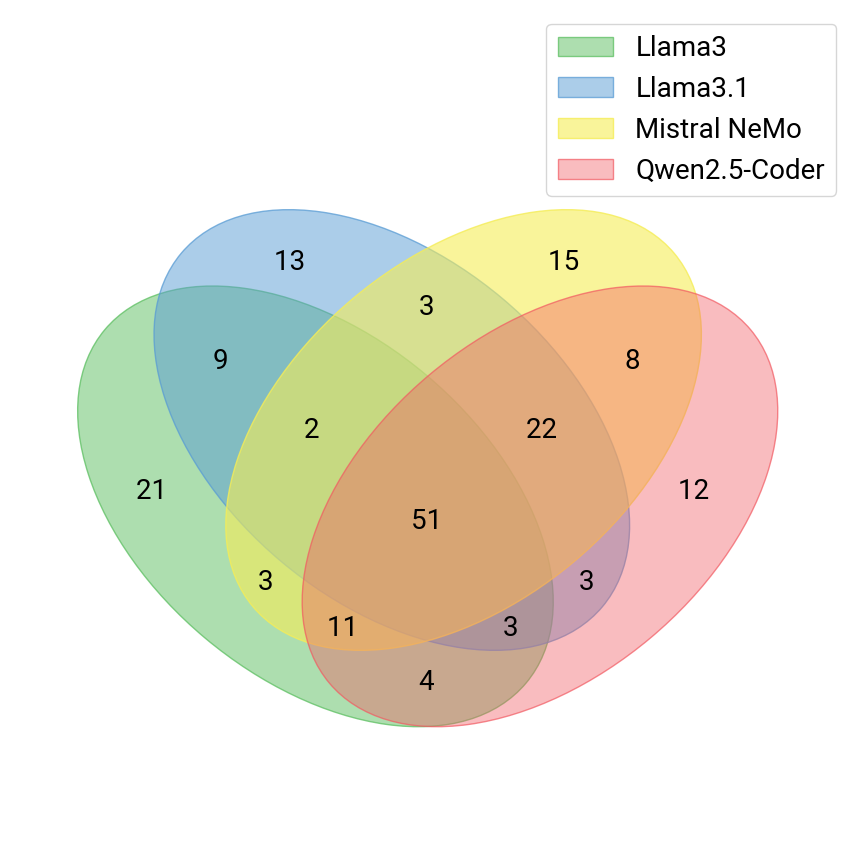

In [7]:
target_paths = [\
    '../autofl/combined_fl_results/d4j_eol_llama3_R5.json',\
    '../autofl/combined_fl_results/d4j_eol_llama31_R5.json',\
    '../autofl/combined_fl_results/d4j_eol_mistral_nemo_R5.json',\
    '../autofl/combined_fl_results/d4j_eol_qwen25_coder_R5.json',\
]
target_sets = [read_combined_fl_result(path) for path in target_paths]

labels = venn.get_labels(target_sets, fill=['number'])
venn.venn4(labels, names=['Llama3', 'Llama3.1', 'Mistral NeMo', 'Qwen2.5-Coder'], fontsize=20)
plt.tight_layout()
plt.savefig('RQ1/orthogonal.pdf', dpi=300)
plt.show()

### acc@1 over runs, for each model + ensemble /  R= 4 ~ 24

In [8]:
def load_acc_at_1_for_dir(result_dir, file_prefix, acc_keyword, is_ensemble, max_R):
    result = dict()
    files = sorted([(file, int(file.split('_')[-2][1:]) * 4 if is_ensemble else int(file.split('_')[-2][1:])) for file in os.listdir(result_dir) if file.startswith(file_prefix)], key=lambda file: file[1])
    for file_path, run_count in files:
        with open(os.path.join(result_dir, file_path)) as f:
           data = json.load(f)
        if run_count > max_R or run_count < 4:
            continue
        if run_count not in result:
            result[run_count] = list()
        result[run_count].append(data[acc_keyword][0])
    return pd.DataFrame(result)

In [9]:
def plot_mean(acc_over_runs, title_label, color, marker, linestyle, ax):
    mean = acc_over_runs.mean()
    x = acc_over_runs.columns
    ax.plot(x, mean, color=color, marker=marker, linestyle=linestyle, label=title_label)

def plot_mean_of_dir(result_dir, label, file_prefix, acc_keyword, color, is_ensemble, max_R, ax):
    if is_ensemble:
        plot_mean(load_acc_at_1_for_dir(result_dir, file_prefix, acc_keyword, is_ensemble, max_R), label, color, 'x', '-', ax)
    else:
        plot_mean(load_acc_at_1_for_dir(result_dir, file_prefix, acc_keyword, is_ensemble, max_R), label, color, '.', '-.', ax) 

In [10]:
def draw_all_plots_on_one_figure(results, max_R):
    all_colors = ['blue', 'red']
    all_colors.extend(colors)
    
    _, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlabel('Number of Runs')
    ax.set_xticks([4 * i for i in range(1, max_R)])
    ax.set_ylabel('Mean of acc@1')
    ax.set_title(f'acc@1 over runs')
    ax.grid(True, linestyle='--')

    for i, (dir, label, prefix, accs_keyword, is_ensemble) in enumerate(results):
        plot_mean_of_dir(dir, label, prefix, accs_keyword, all_colors[i], is_ensemble, max_R, ax)
    
    ax.legend()
    plt.tight_layout()
    plt.savefig('RQ1/accatone.pdf', dpi=300)
    plt.show()

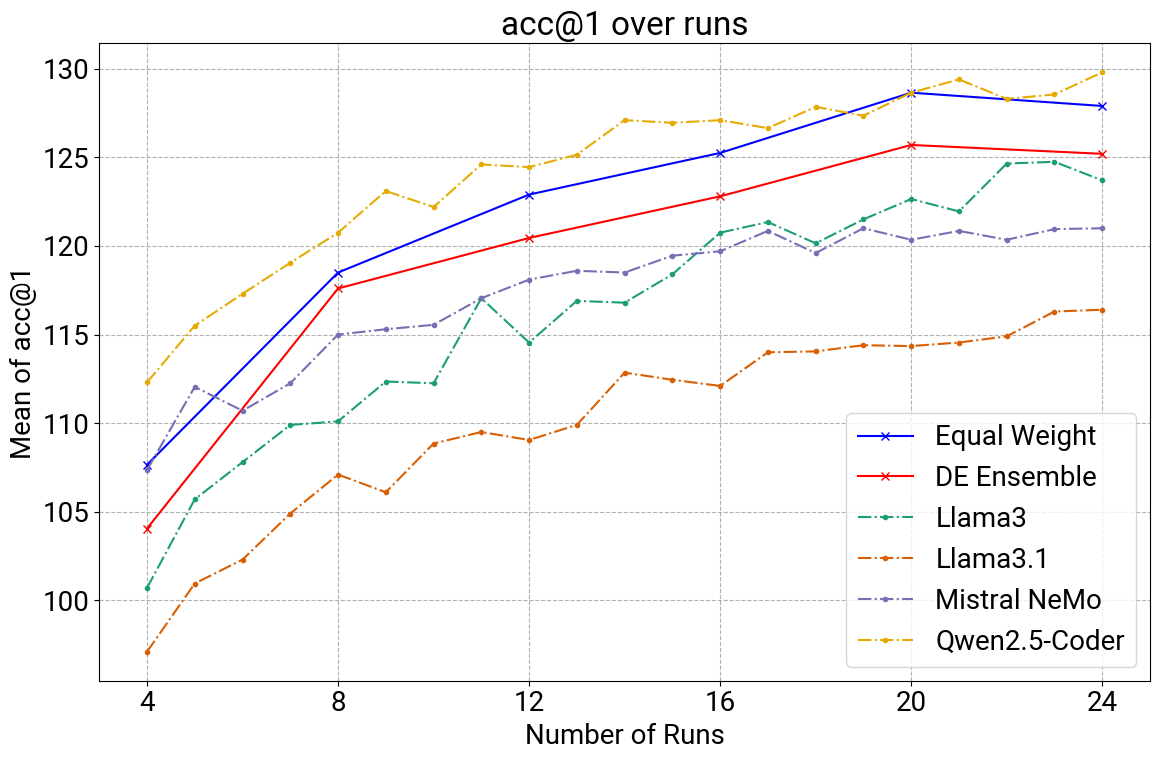

In [11]:
draw_all_plots_on_one_figure(experiment_results, max_R=24)

### Weight Fluctuations

In [12]:
def retrieve_weights_from_json(path):
    with open(path, 'r') as file:
        data = json.load(file)        
    return [data[key]['best'] for key in data.keys() if key.isdigit()]

def get_mean_best_weights(base_dir, R, N):
    weights = list()
    for i in range(1, N + 1):
        weights.append(retrieve_weights_from_json(f'{base_dir}/de_CV_R{R}_{i}.json'))

    weights = np.array(weights).reshape(-1, 4)
    weights = weights / np.sum(weights, axis=1).reshape(-1, 1)
    return weights.mean(axis=0)

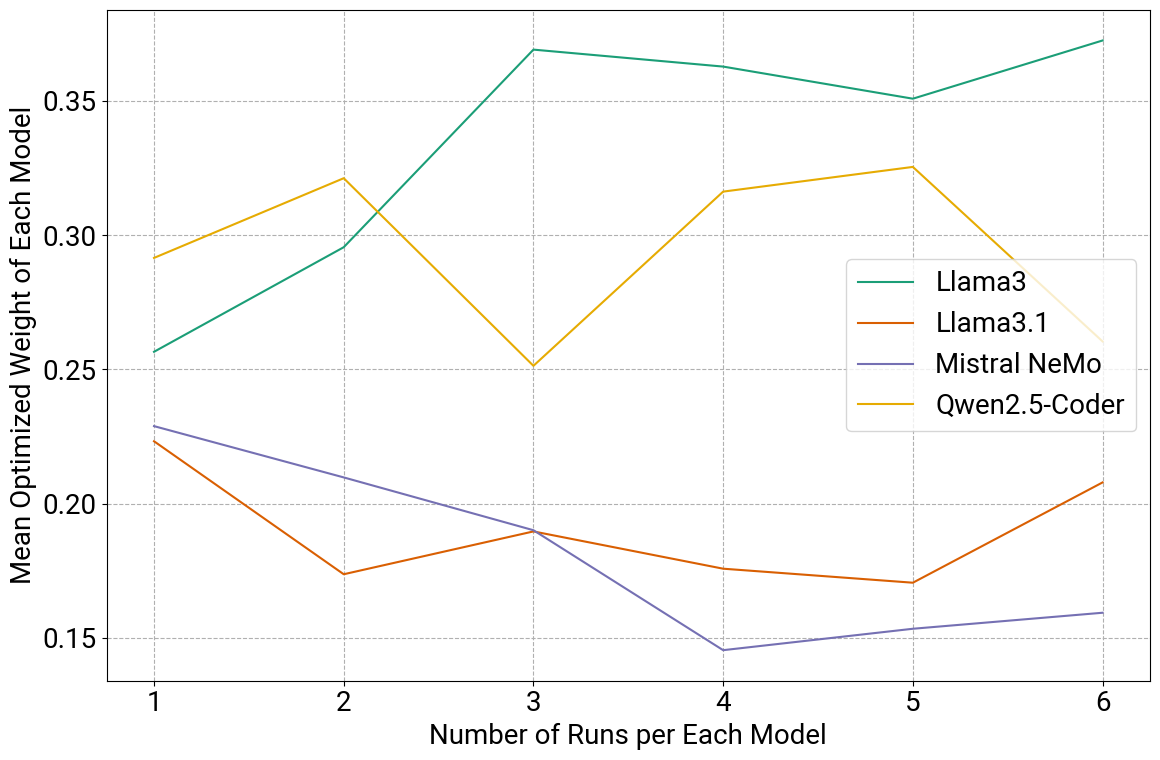

In [13]:
mean_best_weights = list()
labels = [f'Llama3', f'Llama3.1', f'Mistral NeMo', f'Qwen2.5-Coder']

for R in range(1, 7):
    mean_best_weights.append(get_mean_best_weights('../autofl/weighted_fl_results/accat1_de', R, 20))
mean_best_weights = np.array(mean_best_weights).T

plt.figure(figsize=(12, 8))
for i, best in enumerate(mean_best_weights):
    plt.plot(range(1, 7), best, label=labels[i], color=colors[i])
plt.xlabel('Number of Runs per Each Model')
plt.ylabel('Mean Optimized Weight of Each Model')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.legend()
plt.savefig('RQ1/best_weights.pdf', dpi=300)

### distribution of acc@1 for each model + ensemble / R = 4 ~ 24

In [14]:
def plot_median_with_ci(acc_over_runs, title_label, ax): 
    median = acc_over_runs.median()
    ci_95 = acc_over_runs.quantile([0.025, 0.975])
    ci_80 = acc_over_runs.quantile([0.1, 0.9])
    ci_50 = acc_over_runs.quantile([0.25, 0.75])
    
    x = acc_over_runs.columns

    ax.plot(x, median, color='black', label='Median')
    ax.fill_between(x, ci_95.loc[0.025], ci_95.loc[0.975], color='#004c6d', alpha=0.2, label='95% interval')
    ax.fill_between(x, ci_80.loc[0.1], ci_80.loc[0.9], color='#0076aa', alpha=0.4, label='80% interval')
    ax.fill_between(x, ci_50.loc[0.25], ci_50.loc[0.75], color='#00a2ec', alpha=0.6, label='50% interval')

    print('Min-Max difference', max((ci_95.loc[0.975] / ci_95.loc[0.025] - 1) * 100))

    ax.set_xticks(range(4, 25, 4))
    ax.set_xticklabels([])
    ax.set_yticks(range(100, 141, 10))
    # ax.set_yticklabels([])
    ax.set_ylim(90, 140)
    ax.set_title(title_label)
    ax.grid(True, linestyle='--')

def plot_ci_of_dir(result_dir, label, file_prefix, acc_keyword, is_ensemble, ax, max_R=24):
    plot_median_with_ci(load_acc_at_1_for_dir(result_dir, file_prefix, acc_keyword, is_ensemble, max_R), label, ax)

In [15]:
def draw_ci_plots_for_dirs(results):
    fig, axes = plt.subplots(len(results)//2, 2, figsize=(14, 14))
    
    for i, (dir, label, prefix, accs_keyword, is_ensemble) in enumerate(results):
        if is_ensemble:
            plot_ci_of_dir(dir, label, prefix, accs_keyword, is_ensemble, axes[i//2, i%2])
        else:
            plot_ci_of_dir(dir, label, prefix, accs_keyword, is_ensemble, axes[i//2, i%2])

    fig.suptitle('Distribution of acc@1')

    final_plot_index = len(results) - 1 
    for i in range(0, final_plot_index, 2):
        axes[i//2, 0].set_ylabel('acc@1')
    for i in range(2):
        axes[final_plot_index//2, i].set_xticklabels(range(4, 25, 4))
        axes[final_plot_index//2, i].set_xlabel('R')

    axes[final_plot_index//2, final_plot_index%2].legend()

    plt.tight_layout()
    plt.savefig('RQ1/distributions.pdf', dpi=300)
    plt.show()

Min-Max difference 19.116896375701863
Min-Max difference 21.549918547824063
Min-Max difference 21.133736929003867
Min-Max difference 20.494791666666657
Min-Max difference 18.774999999999984
Min-Max difference 15.771270463454012


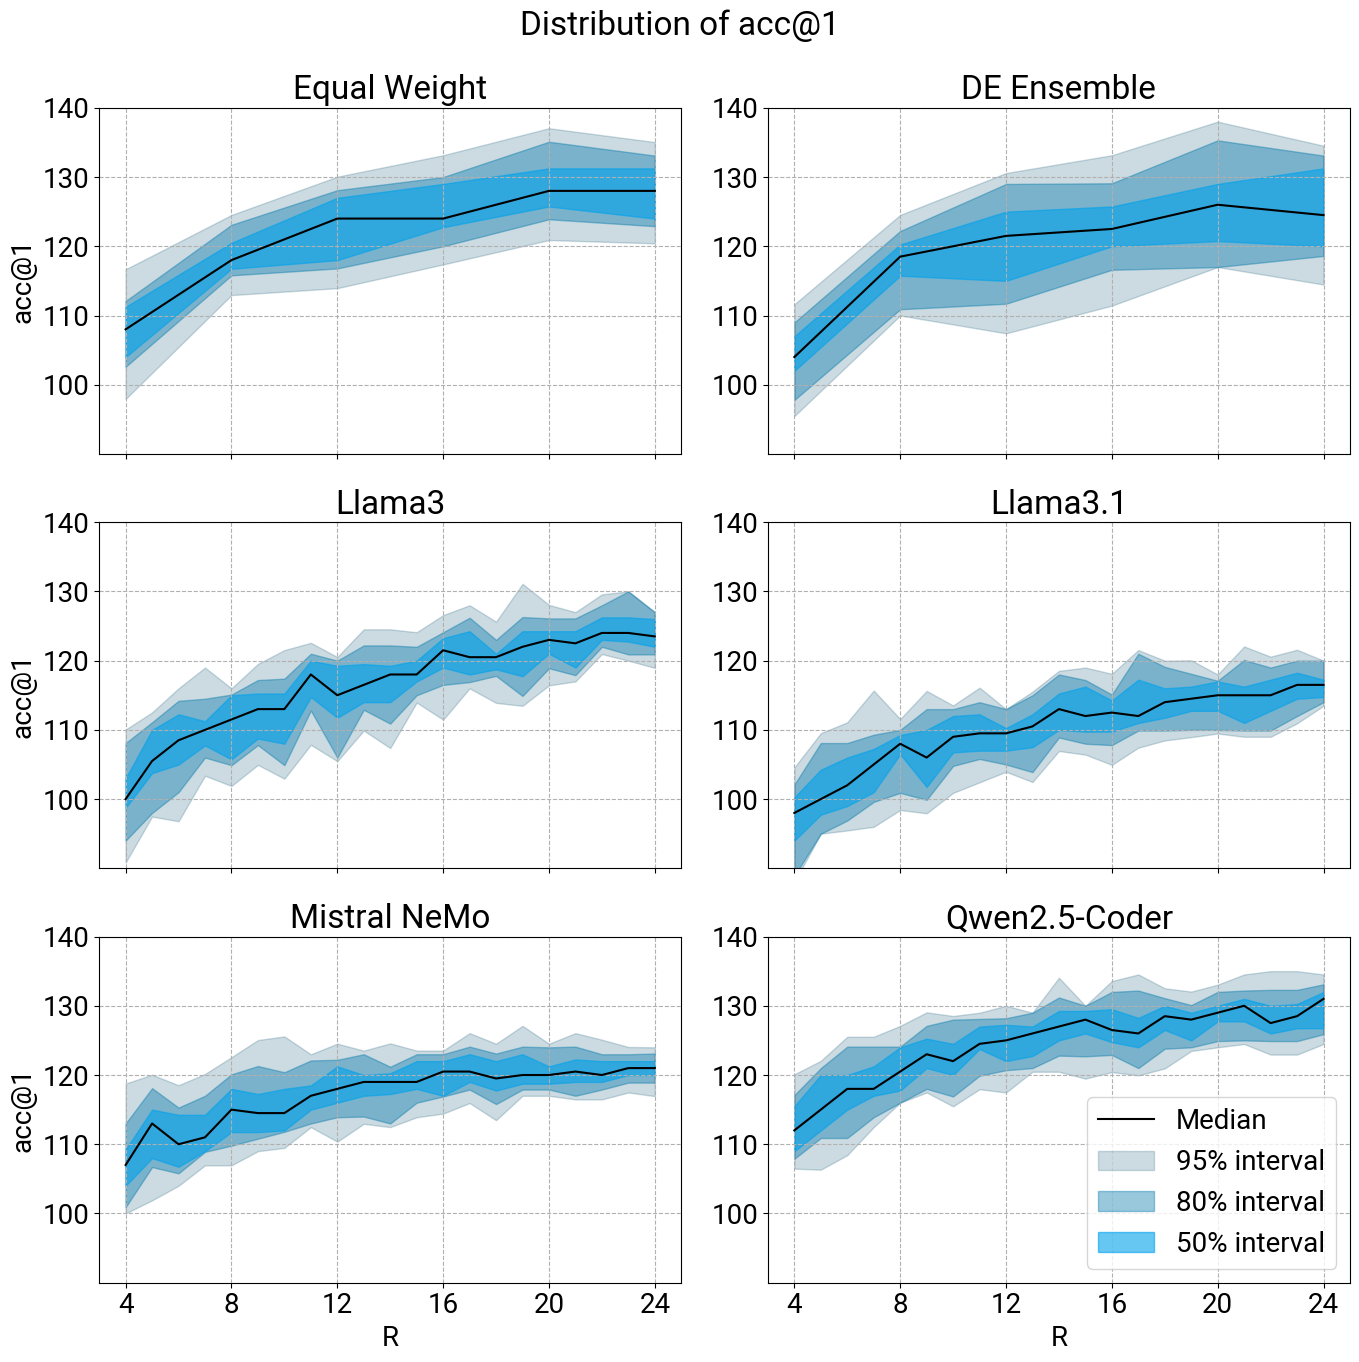

In [16]:
draw_ci_plots_for_dirs(experiment_results)

### acc@1-5 for R=20, for each model + ensemble + GPT baseline /  R= 4 ~ 24

In [17]:
def draw_ks_for_dir(result_dir, label, file_prefix, acc_keyword, is_ensemble, color, ax, R=20, K=5):
    result = dict([(k, []) for k in range(1, K+1)])
    files = sorted([(file, int(file.split('_')[-2][1:]) * 4 if is_ensemble else int(file.split('_')[-2][1:])) for file in os.listdir(result_dir) if file.startswith(file_prefix)], key=lambda file: file[1])
    for file_path, run_count in files:
        with open(os.path.join(result_dir, file_path)) as f:
           data = json.load(f)
        if run_count != R:
            continue
        for k in range(1, K + 1):        
            result[k].append(data[acc_keyword][k - 1])
    if is_ensemble:
        plot_mean(pd.DataFrame(result), label, color, 'o', '-', ax)
    else:
        plot_mean(pd.DataFrame(result), label, color, '.', '-.', ax) 

def draw_accuracies_for_ensemble(results, R=20, K=5):
    all_colors = ['blue', 'red']
    all_colors.extend(colors)

    _, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlabel('k')
    ax.set_xticks(range(1, K + 1))
    ax.set_ylabel(f'Mean of acc@k (R={R})')
    ax.set_title(f'acc@k for R={R}')
    ax.grid(True, linestyle='--')

    for i, (dir, label, prefix, accs_keyword, is_ensemble) in enumerate(results):
        draw_ks_for_dir(dir, label, prefix, accs_keyword, is_ensemble, all_colors[i], ax)

    gpt_baseline_performance = [146, 172, 180, 186, 194]
    ax.plot(range(1, 6), gpt_baseline_performance, color='black', marker='x', linestyle='--', label='GPT3.5 (R=5)')

    ax.legend()
    plt.tight_layout()
    plt.savefig('RQ1/accatks.pdf', dpi=300)
    plt.show()


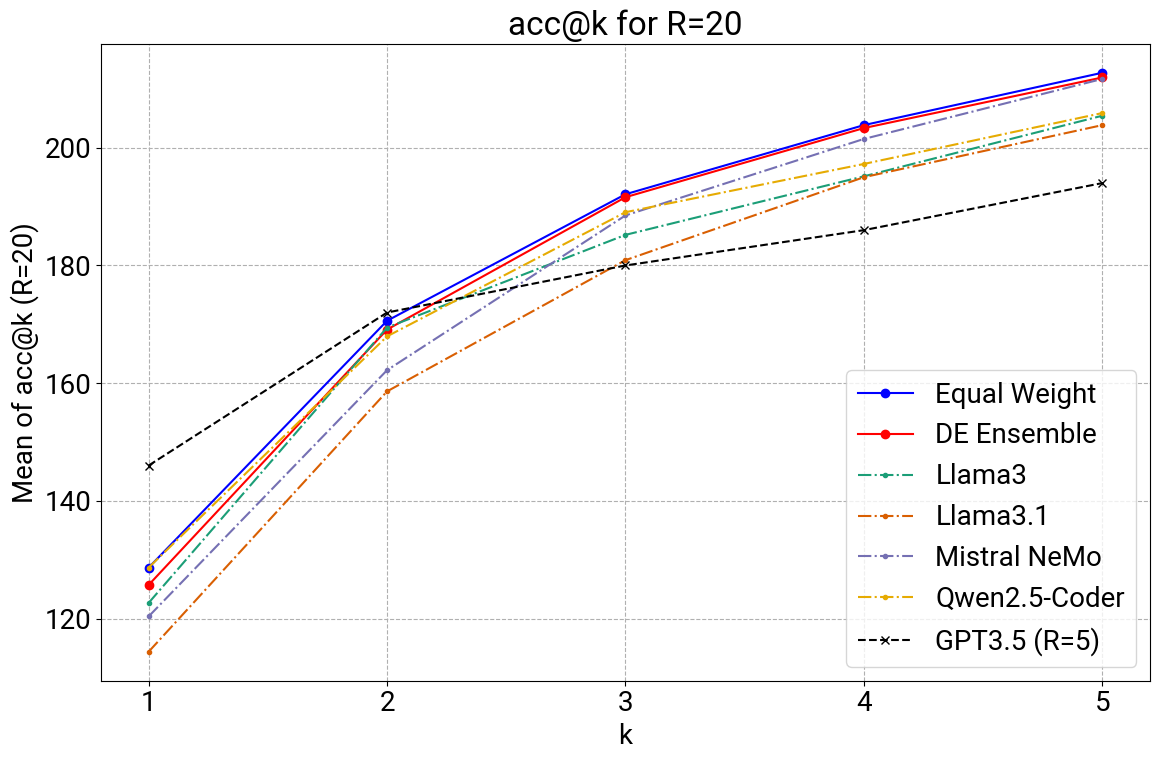

In [18]:
draw_accuracies_for_ensemble(experiment_results)

### ensemble anaylsis for DE vs Equal weight? understand deeper before presenting this

In [19]:
def read_combined_fl_result(path, keyword, k=1):
    ranked_at_k = set()
    with open(path) as f:
        result = json.load(f)
    ranks = result[keyword]
    for bug, rank in ranks.items():
        if rank <= k:
            ranked_at_k.add(bug)
    
    return ranked_at_k

def draw_overlap_for_acc_at_k(k):
    target_sets = [read_combined_fl_result('../autofl/weighted_fl_results/same_sample_wef_de_CV.json', 'validation_ranks', k),\
                read_combined_fl_result('../autofl/weighted_fl_results/same_sample_equal.json', 'ranks', k)]
    plt.figure()
    venn2(target_sets, ['', ''])
    plt.savefig(f'RQ1/overlap_acc_at_{k}.png')

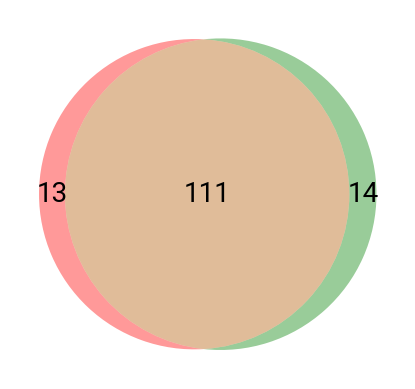

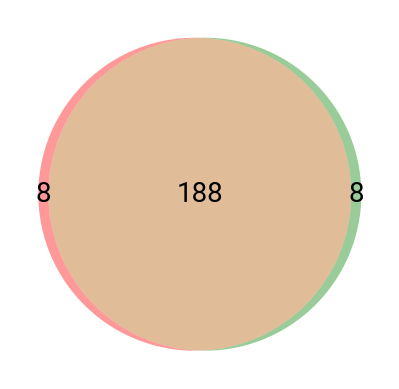

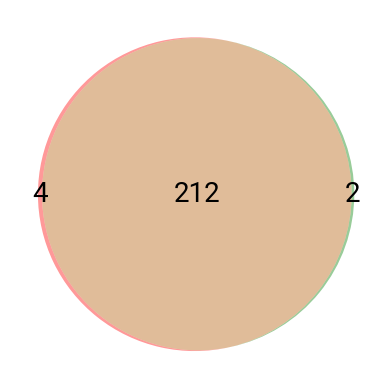

In [20]:
for k in range(1, 6, 2):
    draw_overlap_for_acc_at_k(k)

# RQ 2. Efficiency

### inference cost - performance diagram for each -> optimization cost? negligible?

In [21]:
def cost_of_run(run_dir, cache):
    if run_dir in cache:
        return cache[run_dir]
    file_iterator = sorted(os.listdir(run_dir))
    total_consumption, total_time, total_in_tokens, total_out_tokens = 0, 0, 0, 0
    for fname in file_iterator:
        fpath = os.path.join(run_dir, fname)
        with open(fpath, 'r') as f:
            autofl_data = json.load(f)
        total_consumption += sum(autofl_data["total_energy"])
        total_time += autofl_data["time_taken"]
        queries = autofl_data["query_costs"]
        for query in queries:
            if not query:
                continue
            total_in_tokens += query["prompt_eval_count"]
            total_out_tokens += query["eval_count"]
    
    cache[run_dir] = (total_consumption, total_time, total_in_tokens, total_out_tokens)
    return total_consumption, total_time, total_in_tokens, total_out_tokens

def median_cost_of_sampled_runs(sampled_dirs, cost_cache):
    total_energy_consumptions, total_time, total_in_tokens, total_out_tokens = list(), list(), list(), list()
    for dir_list in sampled_dirs:
        sample_energy_consumptions, sample_time, sample_in_tokens, sample_out_tokens = 0, 0, 0, 0
        for dir in dir_list:
            energy_consumption, time_taken, in_tokens, out_tokens = cost_of_run(f'../autofl/{dir}', cost_cache)
            sample_energy_consumptions += energy_consumption
            sample_time += time_taken
            sample_in_tokens += in_tokens
            sample_out_tokens += out_tokens
        total_energy_consumptions.append(sample_energy_consumptions) 
        total_time.append(sample_time)
        total_in_tokens.append(sample_in_tokens)
        total_out_tokens.append(sample_out_tokens)
    print(total_energy_consumptions)
    print("mean", np.mean(total_energy_consumptions))
    print("median", np.median(total_energy_consumptions))
    return np.median(total_energy_consumptions), np.median(total_time), np.median(total_in_tokens), np.median(total_out_tokens)

def mean_cost_of_sampled_runs(sampled_dirs, cost_cache):
    total_energy_consumptions, total_time, total_in_tokens, total_out_tokens = 0, 0, 0, 0
    for dir_list in sampled_dirs:
        for dir in dir_list:
            energy_consumption, time_taken, in_tokens, out_tokens = cost_of_run(f'../autofl/{dir}', cost_cache)
            total_energy_consumptions += energy_consumption
            total_time += time_taken
            total_in_tokens += in_tokens
            total_out_tokens += out_tokens
    return total_energy_consumptions / len(sampled_dirs), total_time / len(sampled_dirs), total_in_tokens / len(sampled_dirs), total_out_tokens / len(sampled_dirs)

def load_sampled_results(ensemble_dir, cost_cache, file_prefix, accs_keyword, R):
    ensemble_perfs = list()
    sampled_dirs = list()
    files = [file for file in os.listdir(ensemble_dir) if file.startswith(file_prefix) and int(file.split('_')[-2][1:]) == R]
    for file_path in files:
        with open(os.path.join(ensemble_dir, file_path)) as f:
            data = json.load(f)
        ensemble_perfs.append(data[accs_keyword][0]) # total_accs for CV, accs otherwise
        sampled_dirs.append(data['sampled_dirs'])
    ensemble_energy, ensemble_time, ensemble_in_tokens, ensemble_out_tokens = mean_cost_of_sampled_runs(sampled_dirs, cost_cache)
    return ensemble_perfs, ensemble_energy, ensemble_time, ensemble_in_tokens, ensemble_out_tokens

In [22]:
def plot_scatter_for_perf_energy(results, models):
    ensemble_runs = [1, 2, 3, 4, 5, 6]
    cost_cache = dict()
    
    _, ax = plt.subplots(figsize=(10, 8))
    total_perfs = list()
    total_energies = list()
    for R in ensemble_runs:
        # load perf & cost -> above methods + blocks above
        perfs = list()
        energies = list()
        for dir, _, file_prefix, acc_keyword, is_ensemble in results:
            if not is_ensemble:
                sampled_perfs, sampled_energy, _, _, _ = load_sampled_results(dir, cost_cache, file_prefix, acc_keyword, R * 4)
            else:
                sampled_perfs, sampled_energy, _, _, _ = load_sampled_results(dir, cost_cache, file_prefix, acc_keyword, R)
            perfs.append(pd.Series(sampled_perfs).mean())
            energies.append(sampled_energy / (10 ** 6))

        total_perfs.append(perfs)
        total_energies.append(energies)

    total_perfs = np.array(total_perfs)
    total_energies = np.array(total_energies)

    line_handles = []

    line, = ax.plot(total_energies[:, 0], total_perfs[:, 0], label='Equal Weight', color="blue", linestyle="-")
    line_handles.append(line)
    line, = ax.plot(total_energies[:, 1], total_perfs[:, 1], label='DE Ensemble', color="red", linestyle="-")
    line_handles.append(line)

    for i, model in enumerate(models):
        line, = ax.plot(
            total_energies[:, 2 + i],
            total_perfs[:, 2 + i],
            label=model,
            linestyle='-.',
            color=colors[i]
        )
        line_handles.append(line)

    scatter_handles = []
    scatter_markers = ['.', '^', 's', 'o', 'v', 'D']
    for R in ensemble_runs:
        scatter = ax.scatter(
            total_energies[R - 1],
            total_perfs[R - 1],
            s=100,
            label=f'R={R * len(models)}',
            color="grey",
            marker=scatter_markers[R - 1]
        )
        scatter_handles.append(scatter)

    line_legend = ax.legend(
        handles=line_handles,
        loc='lower right',
        title="Models",
        fontsize='14',
        title_fontsize='14',
        framealpha=0.6,
    )
    scatter_legend = ax.legend(
        handles=scatter_handles,
        loc='center right',
        title="Number of Runs",
        fontsize='14',
        title_fontsize='14',
        framealpha=0.6,
    )
    ax.add_artist(line_legend)
    ax.add_artist(scatter_legend)

    ax.set_xlabel('Energy Consumption per Sample(MJ)')
    ax.grid(True, linestyle='--')
    ax.set_ylabel('Mean of acc@1')

    plt.tight_layout()
    plt.savefig('RQ2/acc_energy.pdf', dpi=300)
    plt.show()

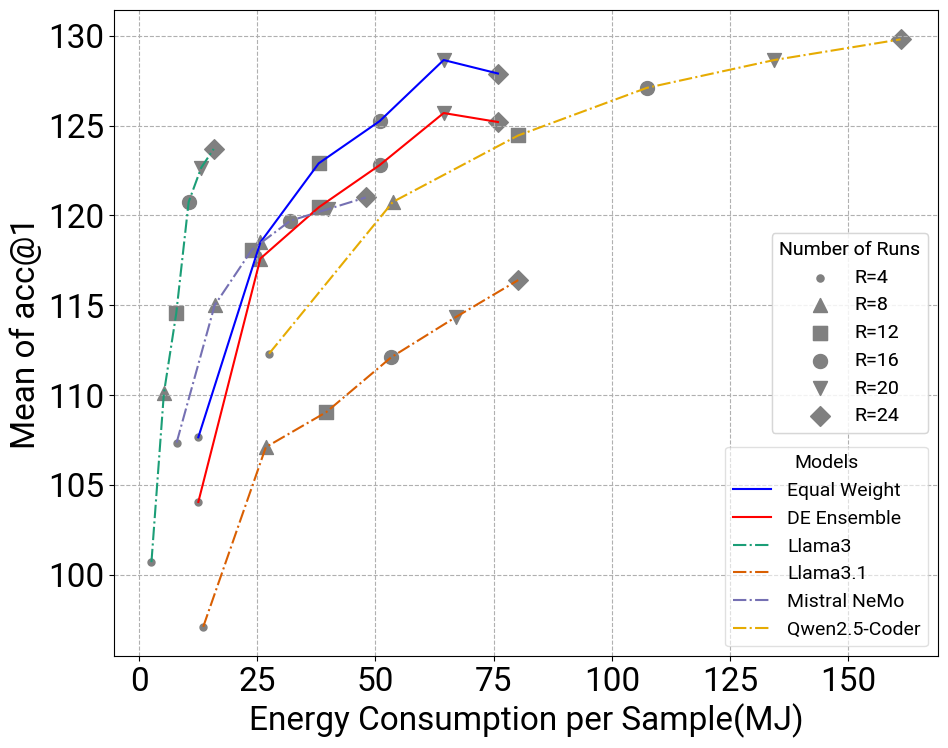

In [23]:
plt.rc('font', size=24)
plot_scatter_for_perf_energy(experiment_results, ['Llama3', 'Llama3.1', 'Mistral NeMo', 'Qwen2.5-Coder'])

In [24]:
def plot_scatter_for_perf_time(results, models):
    ensemble_runs = [1, 2, 3, 4, 5, 6]
    cost_cache = dict()
    
    _, ax = plt.subplots(figsize=(10, 8))
    total_perfs = list()
    total_times = list()
    for R in ensemble_runs:
        # load perf & cost -> above methods + blocks above
        perfs = list()
        times = list()
        for dir, _, file_prefix, acc_keyword, is_ensemble in results:
            if not is_ensemble:
                sampled_perfs, _, sampled_time, _, _ = load_sampled_results(dir, cost_cache, file_prefix, acc_keyword, R * 4)
            else:
                sampled_perfs, _, sampled_time, _, _ = load_sampled_results(dir, cost_cache, file_prefix, acc_keyword, R)
            perfs.append(pd.Series(sampled_perfs).mean())
            times.append(sampled_time / (60 * 60))

        total_perfs.append(perfs)
        total_times.append(times)

    total_perfs = np.array(total_perfs)
    total_times = np.array(total_times)

    line_handles = []

    line, = ax.plot(total_times[:, 0], total_perfs[:, 0], label='Equal Weight', color="blue", linestyle="-")
    line_handles.append(line)
    line, = ax.plot(total_times[:, 1], total_perfs[:, 1], label='DE Ensemble', color="red", linestyle="-")
    line_handles.append(line)

    for i, model in enumerate(models):
        line, = ax.plot(
            total_times[:, 2 + i],
            total_perfs[:, 2 + i],
            label=model,
            linestyle='-.',
            color=colors[i]
        )
        line_handles.append(line)

    scatter_handles = []
    scatter_markers = ['.', '^', 's', 'o', 'v', 'D']
    for R in ensemble_runs:
        scatter = ax.scatter(
            total_times[R - 1],
            total_perfs[R - 1],
            s=100,
            label=f'R={R * len(models)}',
            color="grey",
            marker=scatter_markers[R - 1]
        )
        scatter_handles.append(scatter)

    line_legend = ax.legend(
        handles=line_handles,
        loc='lower right',
        title="Models",
        fontsize='14',
        title_fontsize='14',
        framealpha=0.6,
    )
    scatter_legend = ax.legend(
        handles=scatter_handles,
        loc='center right',
        title="Number of Runs",
        fontsize='14',
        title_fontsize='14',
        framealpha=0.6,
    )
    ax.add_artist(line_legend)
    ax.add_artist(scatter_legend)

    ax.set_xlabel('Time taken per Sample(hour)')
    ax.grid(True, linestyle='--')
    ax.set_ylabel('Mean of acc@1')

    plt.tight_layout()
    plt.savefig('RQ2/acc_time.pdf', dpi=300)
    plt.show()

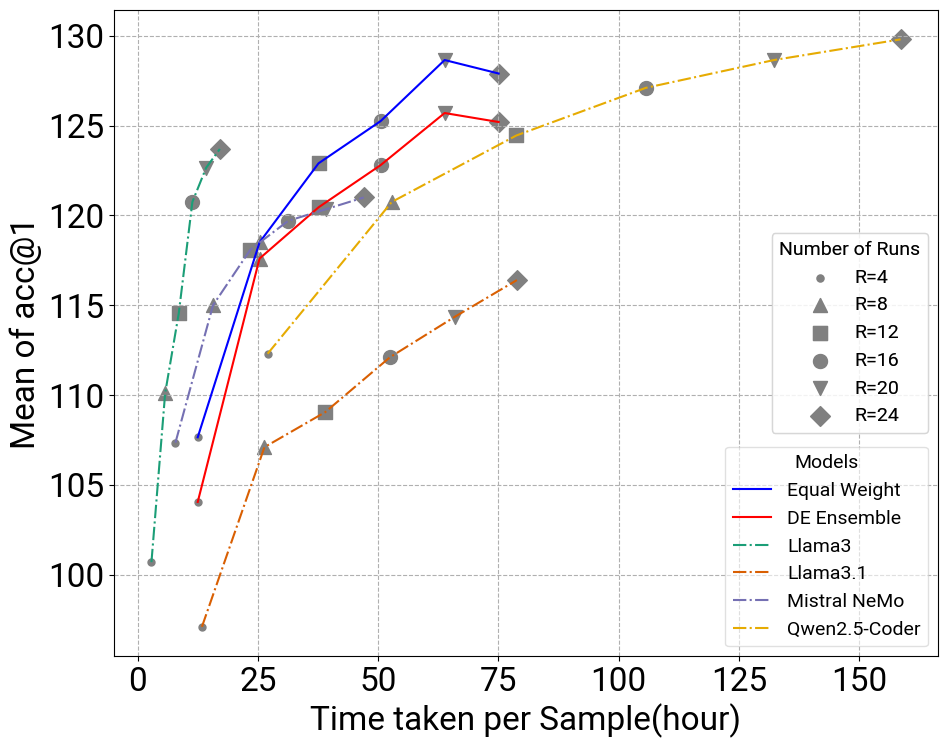

In [25]:
plot_scatter_for_perf_time(experiment_results, ['Llama3', 'Llama3.1', 'Mistral NeMo', 'Qwen2.5-Coder'])

In [26]:
def plot_scatter_for_perf_tokens(results, models):
    ensemble_runs = [1, 2, 3, 4, 5, 6]
    cost_cache = dict()
    
    _, ax = plt.subplots(figsize=(10, 8))
    total_perfs = list()
    total_tokens = list()
    for R in ensemble_runs:
        # load perf & cost -> above methods + blocks above
        perfs = list()
        tokens = list()
        for dir, _, file_prefix, acc_keyword, is_ensemble in results:
            if not is_ensemble:
                sampled_perfs, _, _, in_tokens, out_tokens = load_sampled_results(dir, cost_cache, file_prefix, acc_keyword, R * 4)
            else:
                sampled_perfs, _, _, in_tokens, out_tokens = load_sampled_results(dir, cost_cache, file_prefix, acc_keyword, R)
            perfs.append(pd.Series(sampled_perfs).mean())
            tokens.append((in_tokens + out_tokens) / (10 ** 6))
            # tokens.append((out_tokens) / (10 ** 6))
            # print(in_tokens/10**6, out_tokens/10**6)

        total_perfs.append(perfs)
        total_tokens.append(tokens)

    total_perfs = np.array(total_perfs)
    total_tokens = np.array(total_tokens)

    line_handles = []

    line, = ax.plot(total_tokens[:, 0], total_perfs[:, 0], label='Equal Weight', color="blue", linestyle="-")
    line_handles.append(line)
    line, = ax.plot(total_tokens[:, 1], total_perfs[:, 1], label='DE Ensemble', color="red", linestyle="-")
    line_handles.append(line)

    for i, model in enumerate(models):
        line, = ax.plot(
            total_tokens[:, 2 + i],
            total_perfs[:, 2 + i],
            label=model,
            linestyle='-.',
            color=colors[i]
        )
        line_handles.append(line)

    scatter_handles = []
    scatter_markers = ['.', '^', 's', 'o', 'v', 'D']
    for R in ensemble_runs:
        scatter = ax.scatter(
            total_tokens[R - 1],
            total_perfs[R - 1],
            s=100,
            label=f'R={R * len(models)}',
            color="grey",
            marker=scatter_markers[R - 1]
        )
        scatter_handles.append(scatter)

    line_legend = ax.legend(
        handles=line_handles,
        loc='lower right',
        title="Models",
        fontsize='14',
        title_fontsize='14',
        framealpha=0.6,
    )
    scatter_legend = ax.legend(
        handles=scatter_handles,
        loc='center right',
        title="Number of Runs",
        fontsize='14',
        title_fontsize='14',
        framealpha=0.6,
    )
    ax.add_artist(line_legend)
    ax.add_artist(scatter_legend)

    ax.set_xlabel('# of Tokens Read and Generated per Sample(MTokens)')
    ax.grid(True, linestyle='--')
    ax.set_ylabel('Mean of acc@1')

    plt.tight_layout()
    plt.savefig('RQ2/acc_token.pdf', dpi=300)
    plt.show()

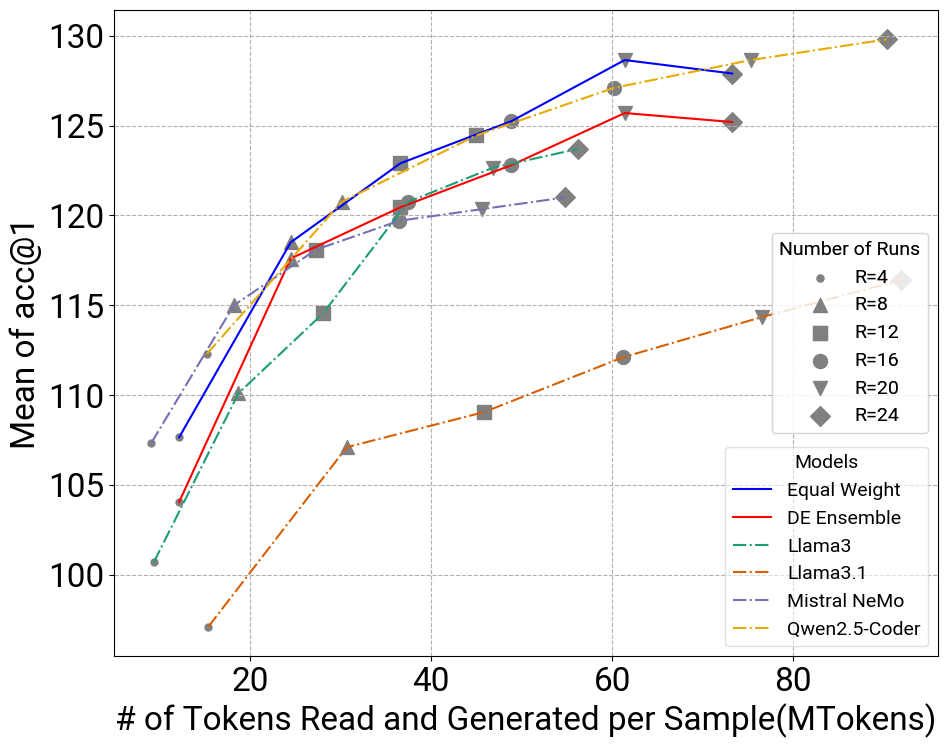

In [27]:
plot_scatter_for_perf_tokens(experiment_results, ['Llama3', 'Llama3.1', 'Mistral NeMo', 'Qwen2.5-Coder'])

### distribution of energy consumption / execution time for each model

In [28]:

def analyze_cost(result_dirs):
    costs = {}
    map_model_dir_to_name = {'llama3': 'Llama3', 'llama3.1': 'Llama3.1', 'mistral-nemo': 'Mistral\nNeMo', 'qwen2.5-coder': 'Qwen2.5\nCoder'}
    for result_dir in result_dirs:
        file_iterator = sorted(os.listdir(result_dir))
        print(f"Processing {result_dir}...")

        model_name = map_model_dir_to_name[result_dir.split('/')[-1]]
        if model_name not in costs:
            costs[model_name] = {'total_energy': list(), 'time_taken': list(), 'tps':list(), 'avg_power': list()}
        for fname in file_iterator:
            fpath = os.path.join(result_dir, fname)
            with open(fpath, 'r') as f:
                autofl_data = json.load(f)
            queries = autofl_data["query_costs"]
            if not queries:
                print(f'WARNING: no queries recorded for {result_dir}/{fname}')
            else:
                generated_tokens = sum([query["eval_count"] for query in queries if "eval_count" in query]) # filter out excessive numbers?
                costs[model_name]['total_energy'].append(sum(autofl_data["total_energy"]))
                costs[model_name]['time_taken'].append(autofl_data['time_taken'])
                costs[model_name]['tps'].append(generated_tokens / autofl_data['time_taken'])
                costs[model_name]['avg_power'].append(sum(autofl_data["total_energy"]) / autofl_data['time_taken']) 
    return costs
    
def save_log_violin_plot(models, y, palette, title, ylabel, output_path): 
    plt.figure(figsize=(10, 7))
    log_y = np.log(np.array(y))
    sns.violinplot(x=models, y=log_y, hue=models, palette=palette)
    
    y_ticks = plt.gca().get_yticks()
    y_tick_labels = [f"$10^{{{int(tick)}}}$" if tick == int(tick) else f"$10^{{{tick:.1f}}}$" for tick in y_ticks]
    plt.yticks(y_ticks, y_tick_labels)
    plt.text(-0.15, 1.05, r"$log_{10}$", transform=plt.gca().transAxes, fontsize=16, style='italic')
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)

def save_box_plot(models, y, palette, title, ylabel, output_path): 
    plt.figure(figsize=(10,7))
    sns.boxplot(x=models, y=y, hue=models, palette=palette)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)

def plot_boxes_for_multi_models(data, path_header):
    models = list()
    original_consumptions = list()
    time_taken = list()
    consumptions_per_second = list()
    tokens_generated_per_second = list()
    
    for model, history in data.items():
        consumptions = history['total_energy']
        times_taken = history['time_taken']
        models.extend([model] * len(consumptions))
        original_consumptions.extend(consumptions)
        time_taken.extend(times_taken)
        tokens_generated_per_second.extend(history['tps'])
        consumptions_per_second.extend([consumption / time_taken for consumption, time_taken in zip(consumptions, times_taken)])

    palette = dict(zip(sorted(set(models)), colors))
    
    save_log_violin_plot(models, np.array(original_consumptions) / 1000, palette, 'Model - Energy Consumptions', 'Energy (kJ)', f'RQ2/{path_header}_energy.pdf')
    save_log_violin_plot(models, time_taken, palette, 'Model - Execution Time', 'Time Taken (sec)', f'RQ2/{path_header}_execution_time.pdf')
    save_box_plot(models, tokens_generated_per_second, palette, 'Model - Tokens Generated per Second', 'Tokens per Second (T/sec)', f'RQ2/{path_header}_tps.pdf')
    save_box_plot(models, consumptions_per_second, palette, 'Model - Energy Consumptions per Second', 'Energy per Second (watt)', f'RQ2/{path_header}_energy_per_seconds.pdf')


Processing ../autofl/results/d4j_autofl_eol_1/llama3...
Processing ../autofl/results/d4j_autofl_eol_1/llama3.1...
Processing ../autofl/results/d4j_autofl_eol_1/mistral-nemo...
Processing ../autofl/results/d4j_autofl_eol_1/qwen2.5-coder...
Processing ../autofl/results/d4j_autofl_eol_2/llama3...
Processing ../autofl/results/d4j_autofl_eol_2/llama3.1...
Processing ../autofl/results/d4j_autofl_eol_2/mistral-nemo...
Processing ../autofl/results/d4j_autofl_eol_2/qwen2.5-coder...
Processing ../autofl/results/d4j_autofl_eol_3/llama3...
Processing ../autofl/results/d4j_autofl_eol_3/llama3.1...
Processing ../autofl/results/d4j_autofl_eol_3/mistral-nemo...
Processing ../autofl/results/d4j_autofl_eol_3/qwen2.5-coder...
Processing ../autofl/results/d4j_autofl_eol_4/llama3...
Processing ../autofl/results/d4j_autofl_eol_4/llama3.1...
Processing ../autofl/results/d4j_autofl_eol_4/mistral-nemo...
Processing ../autofl/results/d4j_autofl_eol_4/qwen2.5-coder...
Processing ../autofl/results/d4j_autofl_eol_

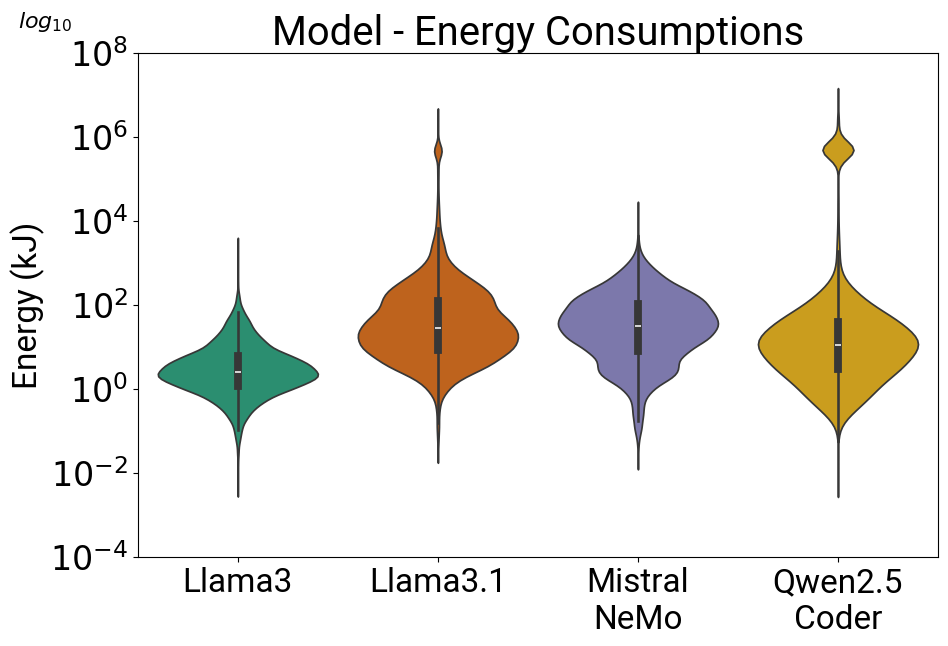

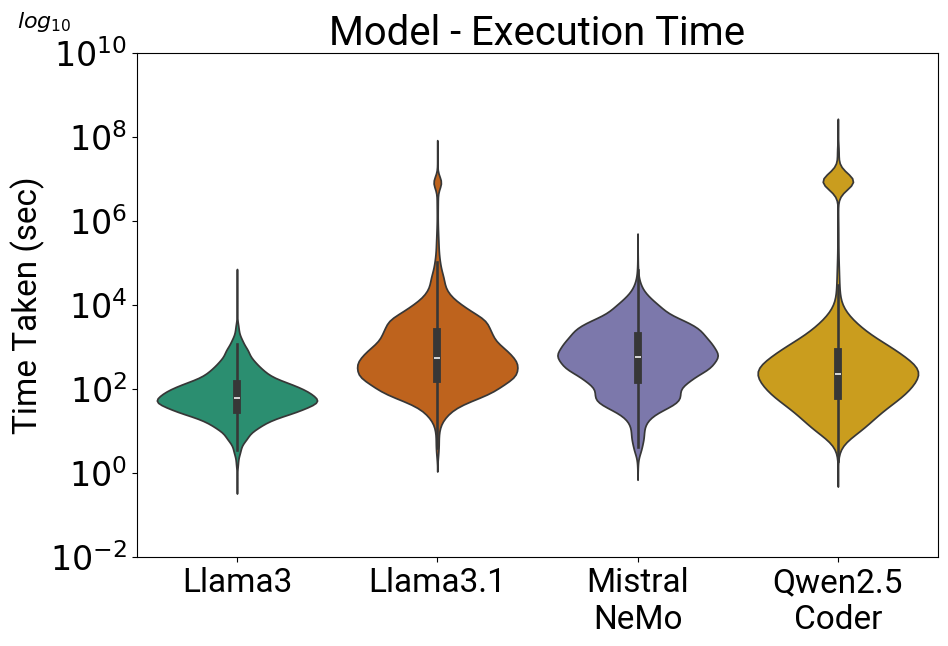

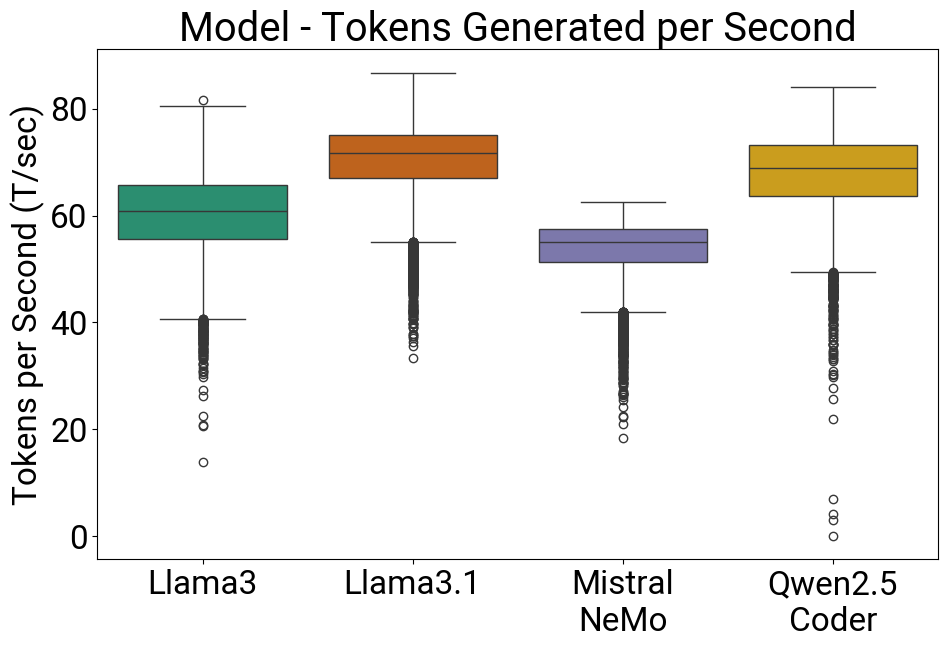

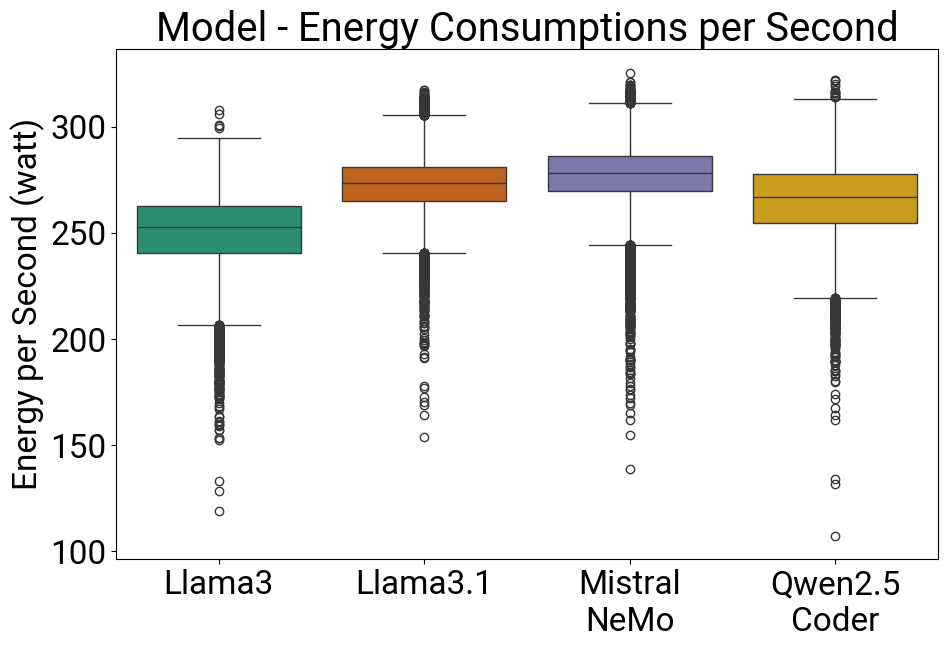

In [29]:
plt.rc('font', size=24)
result_dirs = list()
for i in range(1, 31):
    result_dirs.extend([
        f"../autofl/results/d4j_autofl_eol_{i}/llama3",
        f"../autofl/results/d4j_autofl_eol_{i}/llama3.1",
        f"../autofl/results/d4j_autofl_eol_{i}/mistral-nemo",
        f"../autofl/results/d4j_autofl_eol_{i}/qwen2.5-coder",
    ])
data = analyze_cost(result_dirs)
plot_boxes_for_multi_models(data, "best4")

# Discussion

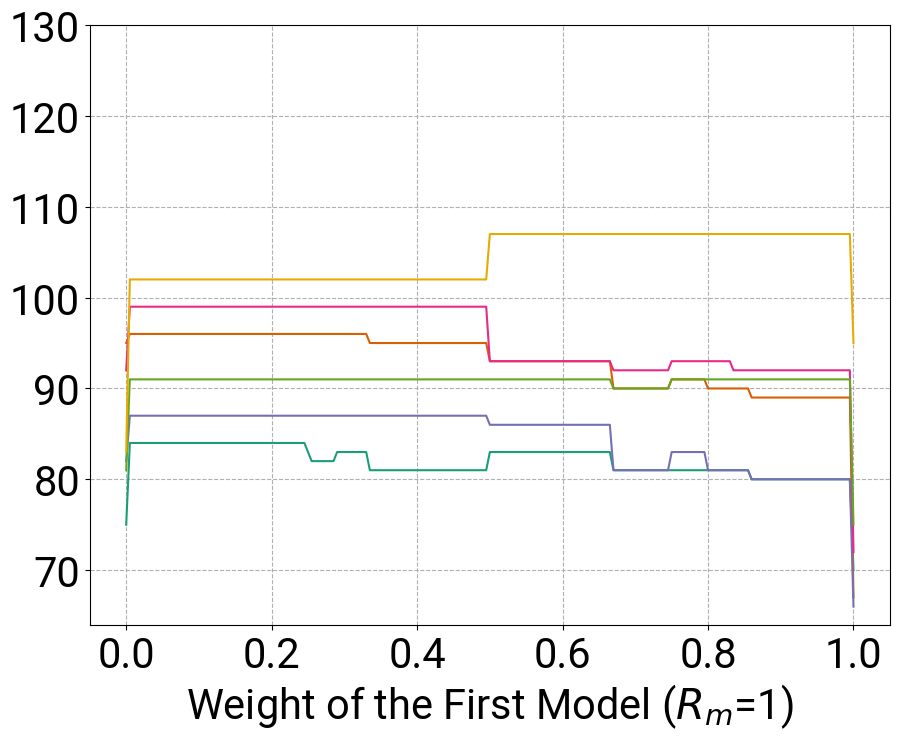

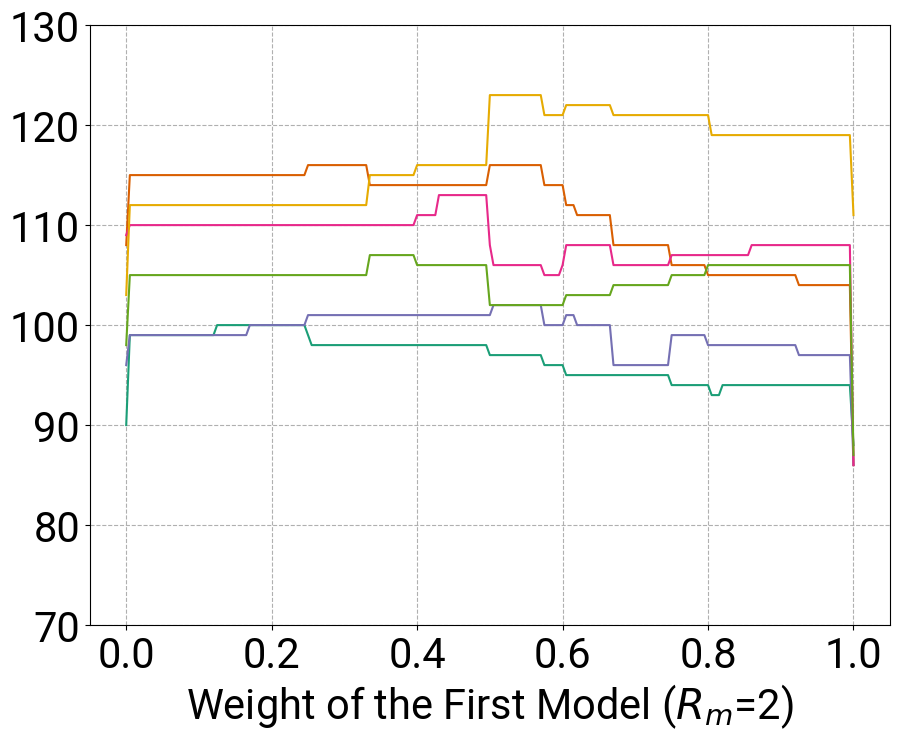

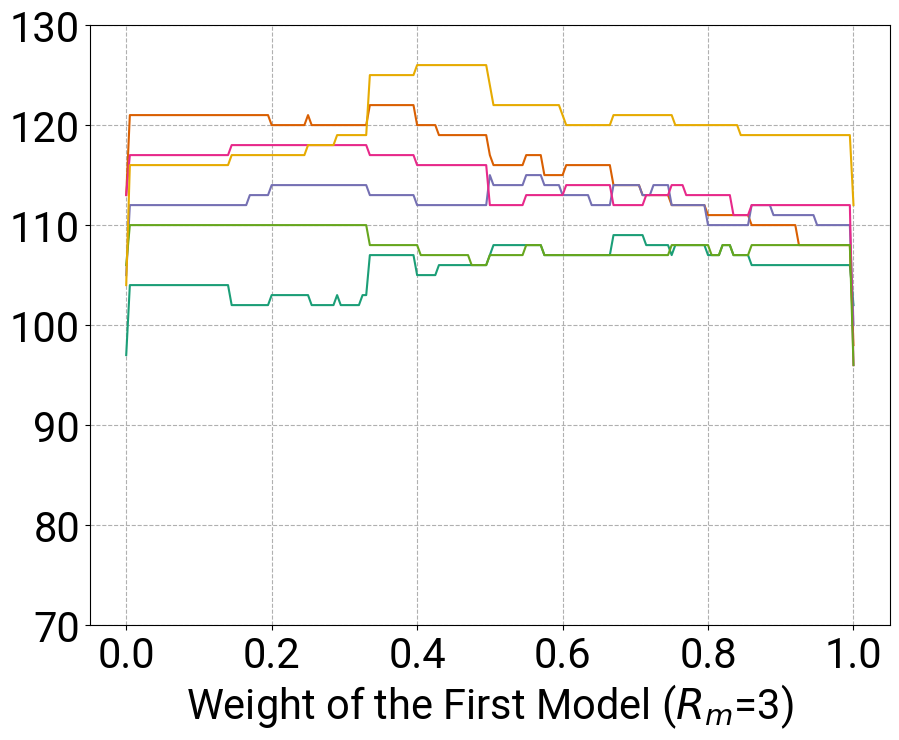

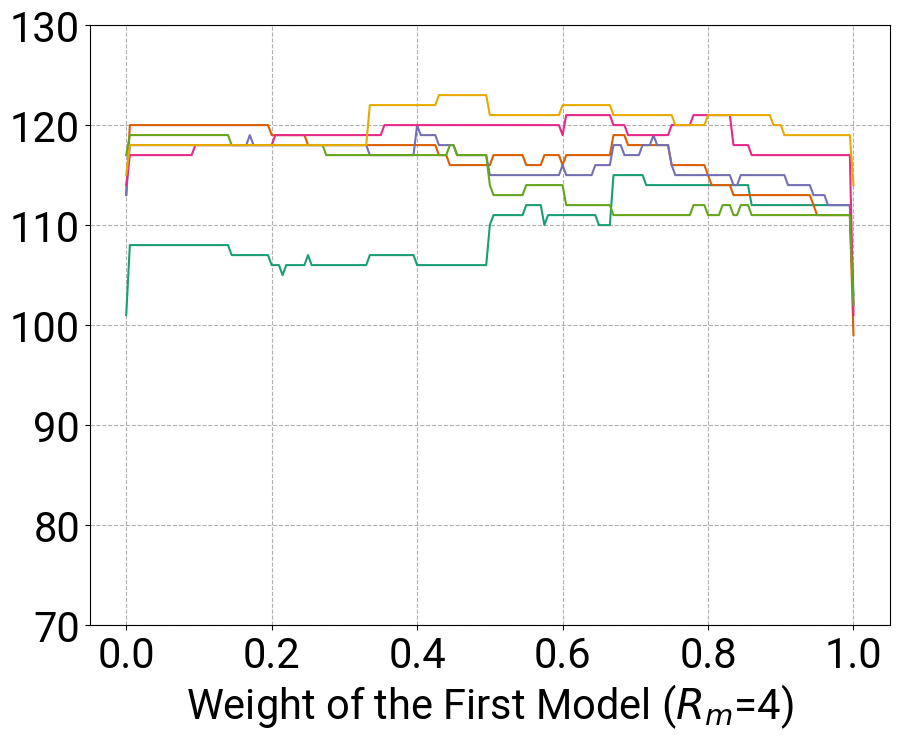

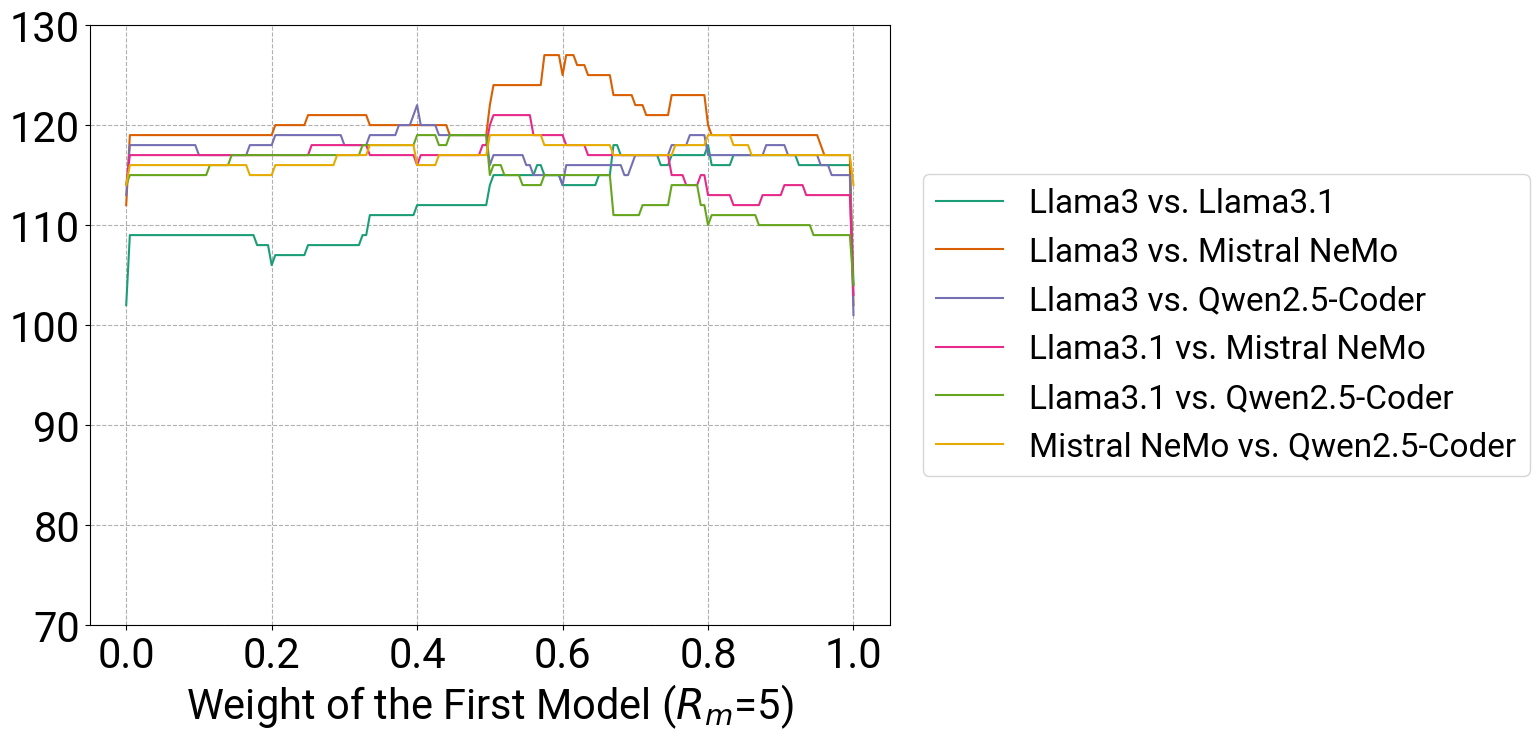

In [25]:
plt.rc('font', size=30)

colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"]
model_map = {"llama3": "Llama3", "llama3.1": "Llama3.1", "mistral-nemo":"Mistral NeMo", "qwen2.5-coder":"Qwen2.5-Coder"}

base_dir = '../autofl/weighted_fl_results/pairwise_grid/'
for R in range(1, 6):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_axes([0, 0, 0.8, 1])

    pairwise_results = [file for file in os.listdir(base_dir)
                        if file.startswith(f'R{R}_') and 'four_models' not in file]
    pairwise_results = sorted(pairwise_results,
                              key=lambda file: list(map(list(model_map.keys()).index, file.split('_')[1:3])))

    for i, file in enumerate(pairwise_results):
        with open(os.path.join(base_dir, file)) as f:
            data = json.load(f)
        model1, model2 = tuple(file.split('_')[1:3])
        weights_of_the_first_model = [point[0] / 2 for point in data['best_weights_over_time']]
        accs = [point[1] for point in data['best_weights_over_time']]
        ax.plot(weights_of_the_first_model, accs,
                label=f'{model_map[model1]} vs. {model_map[model2]}',
                color=colors[i])

    if R == 5:
        ax.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=24)

    ax.set_yticks(range(70, 131, 10))
    ax.set_xlabel(f'Weight of the First Model ({r"$R_m$"}={R})')
    ax.grid(True, linestyle='--')

    fig.savefig(f'Discussions/pairwise_{R}.png', dpi=300, bbox_inches='tight')